In [1]:
import sys
# print(sys.path)
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [1]:
import sys
# print(sys.path)
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [2]:

import os
import argparse
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

import cv2

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

########## following lines are used to create requirements.txt, uncomment if needed
# !pip freeze > requirements_freeze.txt
# !conda env export > environment.yml
# !jupyter nbconvert --to script ad_22032022.ipynb
# !pipreqs --force --encoding utf-8 "/home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/" 


2.6.0


## Data Processing

In [3]:
def showVideo(path_to_file):
    clean_video = cv2.VideoCapture(path_to_file)

    if clean_video.isOpened() == False:
        print("Error opening video stream or file")

    while clean_video.isOpened():
        ret, frame = clean_video.read()
        if ret:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cv2.destroyAllWindows()


In [4]:
def createDirectories():
    path_to_working_directory = os.getcwd()
    if os.path.exists(os.path.join(path_to_working_directory,'dataset')):
        pass  
    else:
        os.mkdir(os.path.join(path_to_working_directory, 'dataset'))

    dataset_path = os.path.join(path_to_working_directory, 'dataset')

    if os.path.exists(os.path.join(dataset_path, 'images')):
        pass
    else: 
        os.mkdir(os.path.join(dataset_path, 'images'))
    images_path = os.path.join(dataset_path, 'images')

    if os.path.exists(os.path.join(dataset_path, 'anomaly_images')):
        pass
    else: 
        os.mkdir(os.path.join(dataset_path, 'anomaly_images'))
    anomaly_images_path = os.path.join(dataset_path, 'anomaly_images')

    if os.path.exists(os.path.join(path_to_working_directory, "models")):
        pass
    else:
        os.mkdir(os.path.join(path_to_working_directory, "models"))
    models_path = os.path.join(path_to_working_directory, "models")

    if os.path.exists(os.path.join(models_path, "autoencoder")):
        pass
    else:
        os.mkdir(os.path.join(models_path, "autoencoder"))
    autoencoder_path = os.path.join(models_path, "autoencoder")

    if os.path.exists(os.path.join(models_path, "supervised_model")):
        pass
    else:
        os.mkdir(os.path.join(models_path, "supervised_model"))
    supervised_model_path = os.path.join(models_path, "supervised_model")

    return dataset_path, images_path, anomaly_images_path, models_path, autoencoder_path, supervised_model_path


In [5]:
def getImagesFromVideo(path_to_clean_images, path_to_anomaly_images, dataset_path, images_path, anomaly_images_path):

    clean_video = cv2.VideoCapture(path_to_clean_images)
    ret, frame = clean_video.read()
    count = 0
    while ret:

        cv2.imwrite(os.path.join(images_path, "images{}.jpg".format(count)), frame)
        ret, frame = clean_video.read()
        count += 1
    print("Done reading {} frames from file {}".format(count, path_to_clean_images))

    anomalous_video = cv2.VideoCapture(path_to_anomaly_images)
    ret, frame = anomalous_video.read()
    count = 0
    while ret:
        cv2.imwrite(os.path.join(anomaly_images_path, "anomaly_images{}.jpg".format(count)), frame)
        ret, frame = anomalous_video.read()
        count += 1
    print("Done reading {} frames from file {}".format(count, path_to_anomaly_images))


In [6]:
def getData(path_to_file, image_size, convert_color = 0):
    imagePaths = list(paths.list_images(path_to_file))
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if convert_color == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        data.append(image)
    data = np.array(data).astype('float32') / 255.
    print("Done creating data for file {}".format(path_to_file))
    visualize_sample = 0
    if visualize_sample == 1:
        cv2.imshow("data", data[0])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return data

In [7]:
path_video_clean_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi'
path_video_anomaly_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi'

# showVideo(path_video_anomaly_data)
dataset_path, images_path, anomaly_images_path, models_path, autoencoder_path, supervised_model_path = createDirectories()

getImagesFromVideo(path_video_clean_data, path_video_anomaly_data, dataset_path, images_path, anomaly_images_path)


Done reading 221 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi
Done reading 161 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi


## Autoencoder

In [8]:
class AnomalyDetector(Model):
    def __init__(self, image_size, hidden_layer_1, hidden_layer_2, channels):
        super(AnomalyDetector, self).__init__()
        self.image_size = image_size
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2
        self.channels = channels

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (image_size, image_size, channels)),
            tf.keras.layers.Conv2D(hidden_layer_1, (3, 3), padding = 'same', strides = 2), 
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(hidden_layer_2, (3, 3), padding = 'same', strides = 2), 
            tf.keras.layers.LeakyReLU(), 
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(hidden_layer_2, kernel_size=3, padding = 'same', strides = 2), 
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(hidden_layer_1, kernel_size=3, padding = 'same', strides = 2),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(channels, 3, padding = 'same', activation = 'sigmoid'),
        ])

    def get_config(self):
        config = {
        "image_size": self.image_size, 
        "hidden_layer_1": self.hidden_layer_1,
        "hidden_layer_2": self.hidden_layer_2,
        "channels": self.channels
        }
        return config 

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [9]:
def splitDataAutoencoder(data):
    train_data, test_data = train_test_split(data, test_size = 0.2, random_state=42)
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)
    if data.shape[-1] != 3:
        train_data = train_data[..., tf.newaxis]
        test_data = test_data[..., tf.newaxis]
    return train_data, test_data

    

In [10]:
def trainModel(model, epochs, batch_size, optimizer, loss, metrics):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    history = model.fit(
        normal_train_data, normal_train_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(normal_test_data, normal_test_data),
        shuffle=True
    )
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()
    try:
        print(model.encoder.summary())
        print(model.decoder.summary())
    except AttributeError:
        print(model.summary())
    # print(model.encoder.summary())
    # print(model.decoder.summary())
    # print(model.summary())
    return history


In [11]:
def plotDifferences(test_data, test_anomaly_data, n):
    encoded_data = autoencoder.encoder(test_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()

    encoded_anomaly_data = autoencoder.encoder(test_anomaly_data).numpy()
    decoded_anomaly_data = autoencoder.decoder(encoded_anomaly_data).numpy()

    

    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(tf.squeeze(test_data[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], test_data[i])))

        bx = plt.subplot(4, n, i + n + 1)
        plt.imshow(tf.squeeze(decoded_data[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
        bx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_data[i], decoded_data[i])))

        cx = plt.subplot(4, n, i + 2*n + 1)
        plt.imshow(tf.squeeze(test_anomaly_data[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)
        cx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_anomaly_data[i], test_anomaly_data[i])))
        
        
        dx = plt.subplot(4, n, i + 3*n + 1)
        plt.imshow(tf.squeeze(decoded_anomaly_data[i]))
        plt.gray()
        dx.get_xaxis().set_visible(False)
        dx.get_yaxis().set_visible(False)
        dx.set_title("SSIMLoss {:.3f}".format(SSIMLoss(test_anomaly_data[i], decoded_anomaly_data[i])))
    plt.show()

In [12]:
# structural similarity between two images in terms of luminance, contrast and structure./
# A value of 1 indicates identical images -> SSIMLoss needs to be minimum (as close as possible to 0)
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [13]:
def calculateLossesMEAN(data, show_plots):
    reconstruction = autoencoder.predict(data)
    train_loss = tf.keras.losses.mae(reconstruction, data)

    train_loss_image = []
    for i in range(len(train_loss)):
        loss_image = np.sum(train_loss[i]) / 255
        train_loss_image.append(loss_image)

    if show_plots == 1:
        plt.hist(train_loss_image, bins=50)
        plt.xlabel("Train loss")
        plt.ylabel("No of examples")
        plt.show()
    return train_loss_image


In [14]:
def calculateLossesSSIM(data):
    predicted = autoencoder.predict(data)
    array_losses = []
    for i in range(len(predicted)):
        loss = SSIMLoss(predicted[i], data[i]).numpy()
        array_losses.append(loss)

    return array_losses


In [15]:
def evaluateLossesMEAN(normal_train_data, anomalous_test_data, show_plots = 0):
    normal_loss_image_mean = calculateLossesMEAN(normal_train_data, show_plots)
    threshold = np.mean(normal_loss_image_mean) + 2 * np.std(normal_loss_image_mean)
    anomalous_loss_image_mean = calculateLossesMEAN(anomalous_test_data, show_plots)
    if show_plots == 1:
        print("Mean + 2 * STD threshold = {}, while the min value of the anomalous loss is {}".format(threshold, np.min(anomalous_loss_image_mean)))

    preds = tf.math.less(normal_loss_image_mean, threshold)
    preds_a = tf.math.greater_equal(anomalous_loss_image_mean, threshold)
    
    print("Correctly evaluated normal data: {} out of {}".format(tf.math.count_nonzero(preds).numpy(), len(normal_loss_image_mean)))
    print("Correctly evaluated anomalous data: {} out of {}".format(tf.math.count_nonzero(preds_a).numpy(), len(anomalous_loss_image_mean)))

In [16]:
def evaluateLossesSSIM(normal_train_data, anomalous_test_data): 
    normal_loss_image_ssim = calculateLossesSSIM(normal_train_data)
    anomalous_loss_image_ssim = calculateLossesSSIM(anomalous_test_data)
    threshold = np.min(anomalous_loss_image_ssim)
    preds = tf.math.less(normal_loss_image_ssim, threshold)
    preds_a = tf.math.greater_equal(anomalous_loss_image_ssim, threshold)
    
    print("Correctly evaluated normal data: {} out of {}".format(tf.math.count_nonzero(preds).numpy(), len(normal_loss_image_ssim)))
    print("Correctly evaluated anomalous data: {} out of {}".format(tf.math.count_nonzero(preds_a).numpy(), len(anomalous_loss_image_ssim)))

In [17]:
image_size = 128
data = getData(images_path, image_size, convert_color = 1)
data_anomaly = getData(anomaly_images_path, image_size, convert_color = 1)

normal_train_data, normal_test_data = splitDataAutoencoder(data)
anomalous_train_data, anomalous_test_data = splitDataAutoencoder(data_anomaly)

epochs = 10
batch_size = 8
hidden_layer_1 = 256
hidden_layer_2 = 128
optimizer = 'adam'
loss = SSIMLoss
metrics = ['mse']
if data.shape[-1] != 3:
    channels = 1
else:
    channels = 3


autoencoder_dir = os.listdir(autoencoder_path)
train = False
if len(autoencoder_dir) == 0 or train == True:
    autoencoder = AnomalyDetector(image_size=image_size, hidden_layer_1 = hidden_layer_1, hidden_layer_2 = hidden_layer_2, channels=channels)
    history_autoencoder = trainModel(autoencoder, epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss = loss, metrics = metrics)
    autoencoder.save(autoencoder_path)
else:
    autoencoder = tf.keras.models.load_model(autoencoder_path, compile = False)


Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/images
Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/anomaly_images


2022-06-17 11:24:35.345547: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 11:24:35.346462: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


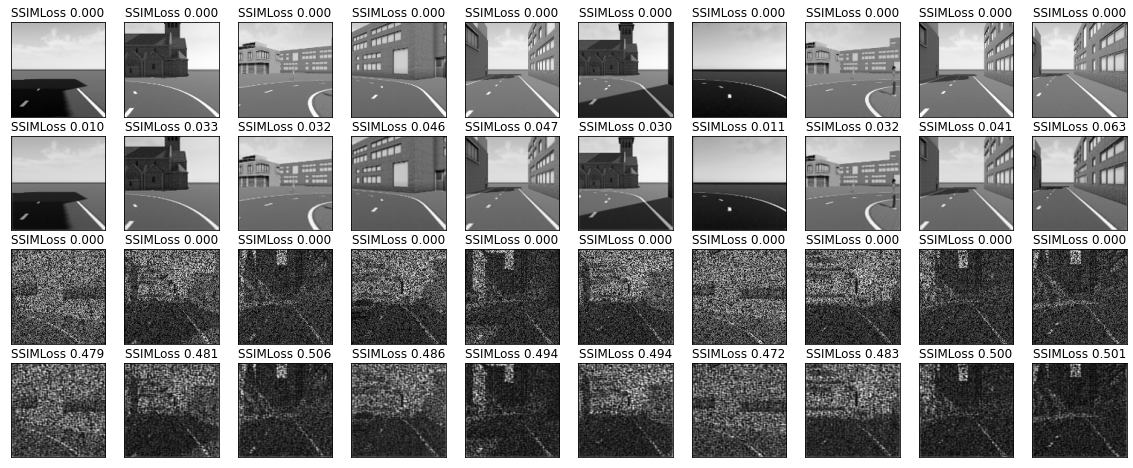

In [18]:
plotDifferences(normal_test_data, anomalous_test_data, 10)

In [19]:
evaluateLossesSSIM(normal_train_data, anomalous_test_data)

2022-06-17 11:24:45.386540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Correctly evaluated normal data: 176 out of 176
Correctly evaluated anomalous data: 33 out of 33


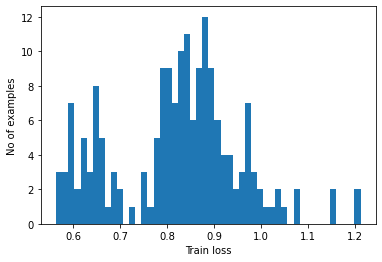

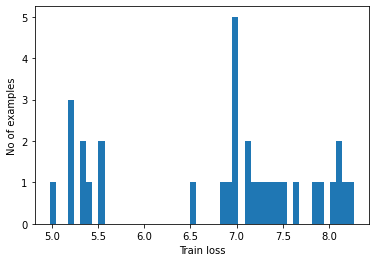

Mean + 2 * STD threshold = 1.0893965056864574, while the min value of the anomalous loss is 4.978219305300245
Correctly evaluated normal data: 172 out of 176
Correctly evaluated anomalous data: 33 out of 33


In [20]:
evaluateLossesMEAN(normal_train_data, anomalous_test_data, show_plots=1)

### Frugally deep Sequential model

In [25]:
model_new = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (image_size, image_size, channels)),
            tf.keras.layers.Conv2D(hidden_layer_1, (3, 3), padding = 'same', strides = 2), 
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(hidden_layer_2, (3, 3), padding = 'same', strides = 2), 
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(hidden_layer_2, (3, 3), padding = 'same', strides = 2),
            # tf.keras.layers.UpSampling2D((2,2)),
              
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(hidden_layer_1, (3, 3), padding = 'same'),
            # tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.UpSampling2D((2,2)),
            tf.keras.layers.Conv2D(channels, (3, 3), padding = 'same', activation = 'sigmoid'),
            # tf.keras.layers.UpSampling2D((2,2)),
            # tf.keras.layers.UpSampling2D((2,2)),
])

# model_new = tf.keras.Sequential()


Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/images
Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/anomaly_images
Epoch 1/10
22/22 [==============================] - 10s 434ms/step - loss: 0.1112 - mse: 0.0129 - val_loss: 0.0623 - val_mse: 8.0706e-04
Epoch 2/10
22/22 [==============================] - 9s 424ms/step - loss: 0.0509 - mse: 6.2941e-04 - val_loss: 0.0489 - val_mse: 7.0954e-04
Epoch 3/10
22/22 [==============================] - 9s 426ms/step - loss: 0.0436 - mse: 5.8379e-04 - val_loss: 0.0442 - val_mse: 5.2569e-04
Epoch 4/10
22/22 [==============================] - 9s 416ms/step - loss: 0.0404 - mse: 4.8100e-04 - val_loss: 0.0423 - val_mse: 4.9674e-04
Epoch 5/10
22/22 [==============================] - 9s 429ms/step - loss: 0.0387 - mse: 4.4482e-04 - val_loss: 0.0405 - val_mse: 4.6911e-04
Epoch 6/10
22/22 [==============================] - 9s 421ms/step - loss: 0.0372 - mse: 4.4529e-04 - val_loss: 

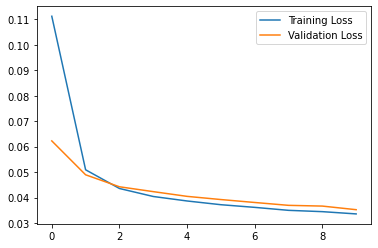

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 256)       2560      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32, 32, 128)      

In [28]:
image_size = 128
data = getData(images_path, image_size, convert_color = 1)
data_anomaly = getData(anomaly_images_path, image_size, convert_color = 1)

normal_train_data, normal_test_data = splitDataAutoencoder(data)
anomalous_train_data, anomalous_test_data = splitDataAutoencoder(data_anomaly)

epochs = 10
batch_size = 8
hidden_layer_1 = 256
hidden_layer_2 = 128
optimizer = 'adam'
loss = SSIMLoss
metrics = ['mse']
if data.shape[-1] != 3:
    channels = 1
else:
    channels = 3

autoencoder_dir = os.listdir(autoencoder_path)

train = True
if len(autoencoder_dir) == 0 or train == True:
    # autoencoder = AnomalyDetector(image_size=image_size, hidden_layer_1 = hidden_layer_1, hidden_layer_2 = hidden_layer_2, channels=channels)
    history_autoencoder = trainModel(model_new, epochs=epochs, batch_size=batch_size, optimizer=optimizer, loss = loss, metrics = metrics)
    model_new.save(autoencoder_path + "/autoencoder_sequential.h5")
else:
    autoencoder = tf.keras.models.load_model(autoencoder_path, compile = False)

## Supervised Learning

In [29]:
image_size = 128
data = getData(images_path, image_size, convert_color=0)
data_anomaly = getData(anomaly_images_path, image_size, convert_color=0)
X = np.concatenate((data, data_anomaly), axis = 0)
y = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0)

Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/images
Done creating data for file /home/adeye/AD-EYE_Core/AD-EYE/Anomaly_Detection/dataset/anomaly_images


In [30]:
X_train, X_aux, y_train, y_aux = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, shuffle=True, stratify=y_aux, test_size=0.2, random_state = 42)

In [31]:
# def augmentImages(image, flip = False, rotation = False):
#     if flip == True:
#         data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip()
#         return data_augmentation(image)
#     elif rotation == True:
#         data_augmentation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
#         return data_augmentation(image)

# augmented_data_flip = augmentImages(X_train, flip = True)
# augmented_data_rotation = augmentImages(X_train, rotation = True)
# X_train_augmented = np.concatenate((X_train, augmented_data_flip, augmented_data_rotation), axis = 0)
# y_train = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0) 

In [37]:
def trainModelSL(hidden_convlayer_1, hidden_convlayer_2, hidden_denselayer_3, optimizer, loss, metrics, epochs, batch_size):
    supervised_model = tf.keras.Sequential([
        # tf.keras.layers.experimental.preprocessing.RandomFlip(),
        # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.InputLayer(input_shape=(
            image_size, image_size, channels)),
        tf.keras.layers.Conv2D(hidden_convlayer_1, 3,
                               padding='same', strides=2, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(hidden_convlayer_2, 3,
                               padding='same', strides=2, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_denselayer_3, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    supervised_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics 
    )
    history_sup = supervised_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_val, y_val),
    )

    plt.plot(history_sup.history["loss"], label="Training Loss")
    plt.plot(history_sup.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

    plt.plot(history_sup.history["accuracy"], label="Training accuracy")
    plt.plot(history_sup.history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.show()

    print(supervised_model.summary())

    return history_sup, supervised_model


In [38]:
def plotPredictions(X_test, y_test, n, width = 20, height = 4):
    y_test_pred = supervised_model.predict(X_test)
    plt.figure(figsize=(width, height))
    if n > len(X_test):
        n = len(X_test)
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(tf.squeeze(X_test[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("True: {}, \n Predicted: {}".format(y_test[i], np.round(y_test_pred[i])[0]))

    plt.show()



Epoch 1/10
17/17 [==============================] - 2s 103ms/step - loss: 0.6424 - accuracy: 0.5768 - val_loss: 0.6002 - val_accuracy: 0.5870
Epoch 2/10
17/17 [==============================] - 1s 59ms/step - loss: 0.5694 - accuracy: 0.5768 - val_loss: 0.5119 - val_accuracy: 0.6196
Epoch 3/10
17/17 [==============================] - 1s 77ms/step - loss: 0.4404 - accuracy: 0.7753 - val_loss: 0.3390 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 2s 93ms/step - loss: 0.2440 - accuracy: 0.9963 - val_loss: 0.1324 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 2s 104ms/step - loss: 0.0789 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 2s 89ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 8/10


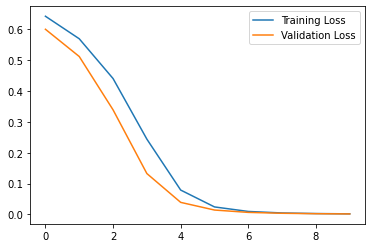

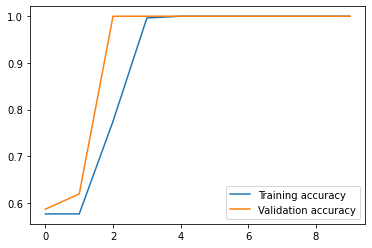

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 4)         292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [39]:
hidden_convlayer_1 = 8 
hidden_convlayer_2 = 4
hidden_denselayer_3 = 16
optimizer = 'adam'
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
epochs = 10
batch_size = 16
channels = data.shape[-1]


supervised_model_dir = os.listdir(supervised_model_path)
train = True


if len(supervised_model_dir) == 0 or train == True:
    history_supervised, supervised_model = trainModelSL(hidden_convlayer_1, hidden_convlayer_2, hidden_denselayer_3, optimizer, loss, metrics, epochs, batch_size)
    supervised_model.save(supervised_model_path)
    supervised_model.save(supervised_model_path + "/supervised_model.h5")
    #supervised_model.save_weights(supervised_model + "/supervised_model.h5")
else:
    supervised_model = tf.keras.models.load_model(supervised_model_path)

In [35]:
test_loss, test_acc = supervised_model.evaluate(X_test, y_test, verbose = 2)

1/1 - 0s - loss: 5.0297e-04 - accuracy: 1.0000


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



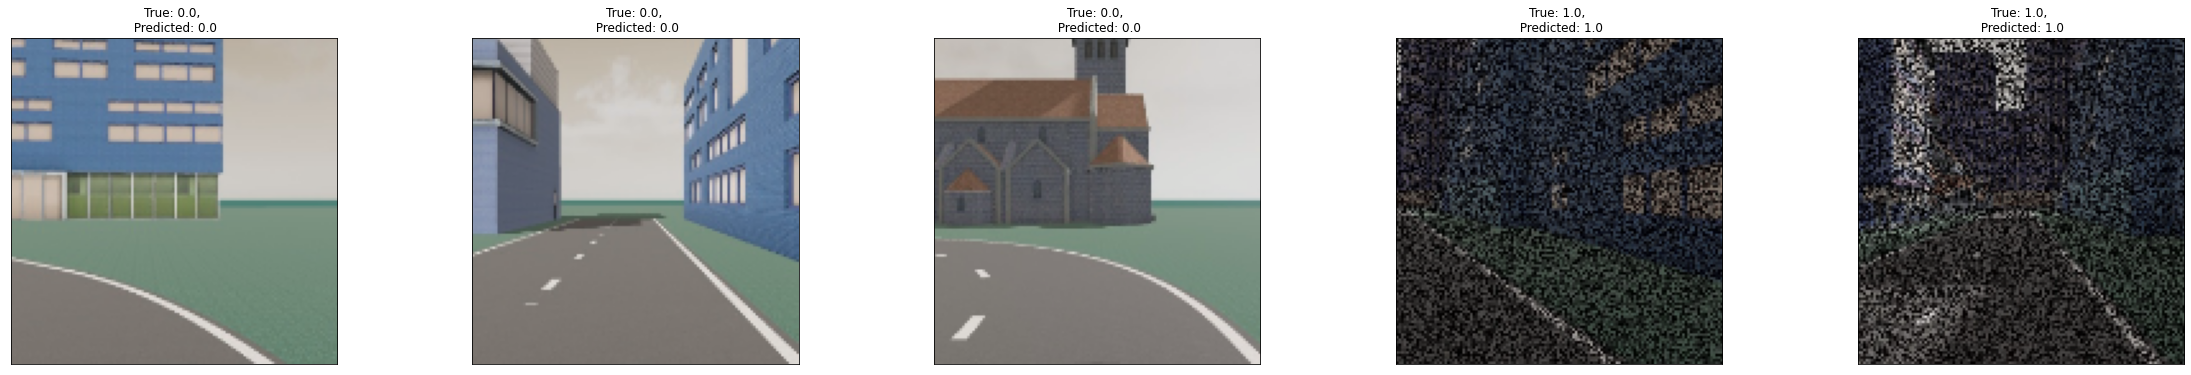

In [36]:
y_test_pred = supervised_model.predict(X_test)
print(classification_report(y_test, np.round(y_test_pred)))
plotPredictions(X_test, y_test, 5, 40, 6)